In [1]:
from keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [4]:
# Generator: 創作者
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
generator = Sequential()
generator.add(Dense(256, input_dim=100, activation="relu"))
generator.add(BatchNormalization())
generator.add(Dense(512, activation="relu"))
generator.add(BatchNormalization())
generator.add(Dense(784, activation="tanh"))
generator.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [3]:
# Discriminator(Loss方程式)
from keras.layers import Dropout
discriminator = Sequential()
discriminator.add(Dense(128, input_dim=784, activation="relu"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation="sigmoid"))
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 先趕快把不固定版本compile住
discriminator.compile(loss="binary_crossentropy",
                      optimizer="adam")

In [10]:
# 1. 訓練Discriminator(不固定)
# 2. 訓練Generator->Discriminator(固定)
from keras.models import Model
discriminator.trainable = False
x = discriminator(generator.output)
combined = Model(inputs=generator.input, outputs=x)
combined.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               402192    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1006

In [0]:
combined.compile(loss="binary_crossentropy",
                 optimizer="adam")

In [0]:
import numpy as np
BATCH = 64
VALID = np.array([1] * 64)
FAKE = np.array([0] * 64)

In [0]:
x_train_reshape = x_train.reshape(60000, 784).astype("float64")
x_train_norm = (x_train_reshape - 127.5) / 127.5

In [46]:
for i in range(1000):
    idx = np.random.randint(0, 60000, BATCH)
    x = x_train_norm[idx]
    # 1. 先訓練D
    # 先給對的
    loss1 = discriminator.train_on_batch(x, VALID)
    # 再給錯的
    r = np.random.normal(0, 1, (BATCH, 100))
    fakes = generator.predict(r)
    loss2 = discriminator.train_on_batch(fakes, FAKE)
    # 2. 訓練G -> D(固定)
    r = np.random.normal(0, 1, (BATCH, 100))
    loss3 = combined.train_on_batch(r, VALID)
    if i % 10 == 9:
        print("<Times>:", i)
        print("D loss:", (loss1 + loss2) / 2)
        print("G loss:", loss3)
        print("-" * 30)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


<Times>: 9
D loss: 0.6882334351539612
G loss: 1.1671602
------------------------------
<Times>: 19
D loss: 0.4855872392654419
G loss: 1.3666573
------------------------------
<Times>: 29
D loss: 0.4809489846229553
G loss: 1.3402683
------------------------------
<Times>: 39
D loss: 1.0046253204345703
G loss: 0.8196422
------------------------------
<Times>: 49
D loss: 0.7655993700027466
G loss: 1.0215728
------------------------------
<Times>: 59
D loss: 0.8508392572402954
G loss: 0.97437704
------------------------------
<Times>: 69
D loss: 1.0303828716278076
G loss: 1.0615141
------------------------------
<Times>: 79
D loss: 1.0758349895477295
G loss: 0.7773994
------------------------------
<Times>: 89
D loss: 0.6864678859710693
G loss: 1.0859244
------------------------------
<Times>: 99
D loss: 0.7023593187332153
G loss: 1.2724999
------------------------------
<Times>: 109
D loss: 0.5799335837364197
G loss: 1.1750703
------------------------------
<Times>: 119
D loss: 0.70814001

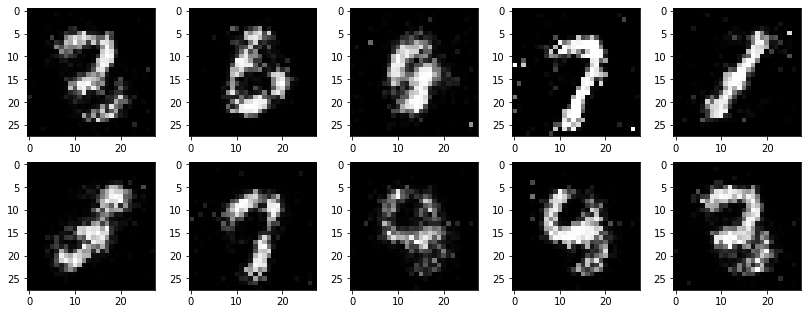

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
r = np.random.normal(0, 1, (10, 100))
imgs = generator.predict(r)
imgs = (imgs + 1.0) / 2.0
plt.figure(figsize=(14, 8))
width = 5
height = len(imgs) // width + 1
for i, img in enumerate(imgs):
    plt.subplot(height, width, i+1)
    img = img.reshape(28, 28)
    plt.imshow(img, cmap="gray")